## **1- importing some libraries**

In [ ]:
#Imports set up
import torch
import zipfile
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import time, os

In [26]:
# Clone the GitHub repo
!git clone https://github.com/salma-033/dog-vs-cat.git

# Unzip the dataset
import zipfile
import os

zip_path = "/content/dog-vs-cat/dogvscat.zip"
extract_dir = "/content/dog-vs-cat/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

# ✅ Fix the real data path (based on ZIP contents)
# List the extracted folders to locate the actual data folder
import os
extracted_root = os.path.join(extract_dir, os.listdir(extract_dir)[0])  # should be something like /content/dog-vs-cat/dataset/dogvscat
data_dir = extracted_root  # This now correctly points to folder with train/val

# PyTorch transforms
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # <- This line was broken before
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'val']
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}
class_names = image_datasets['train'].classes


fatal: destination path 'dog-vs-cat' already exists and is not an empty directory.


In [11]:
from torchvision import models
import torch.nn as nn
import os
from pathlib import Path

# Delete cached resnet18 weights to force re-download
cache_dir = Path(torch.hub.get_dir()) / "checkpoints"
for file in cache_dir.glob("resnet18*"):
    file.unlink()


# Pretrained model loading
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
for param in model.parameters():
    param.requires_grad = False  # freeze layers

num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 2)  # binary classification
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 222MB/s]


In [16]:
# Loss and Optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)



In [17]:
# Loop training
def train_model(model, criterion, optimizer, num_epochs=5):
    train_losses, val_losses, train_acc, val_acc = [], [], [], []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            if phase == 'train':
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc.item())
            else:
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model, train_losses, val_losses, train_acc, val_acc

model, train_losses, val_losses, train_acc, val_acc = train_model(model, criterion, optimizer, num_epochs=5)





Epoch 1/5
----------
train Loss: 0.4644 Acc: 0.8036
val Loss: 0.3475 Acc: 0.8714
Epoch 2/5
----------
train Loss: 0.2999 Acc: 0.9273
val Loss: 0.2308 Acc: 0.9571
Epoch 3/5
----------
train Loss: 0.2169 Acc: 0.9164
val Loss: 0.1958 Acc: 0.9571
Epoch 4/5
----------
train Loss: 0.1560 Acc: 0.9745
val Loss: 0.1637 Acc: 0.9571
Epoch 5/5
----------
train Loss: 0.1429 Acc: 0.9782
val Loss: 0.1500 Acc: 0.9571


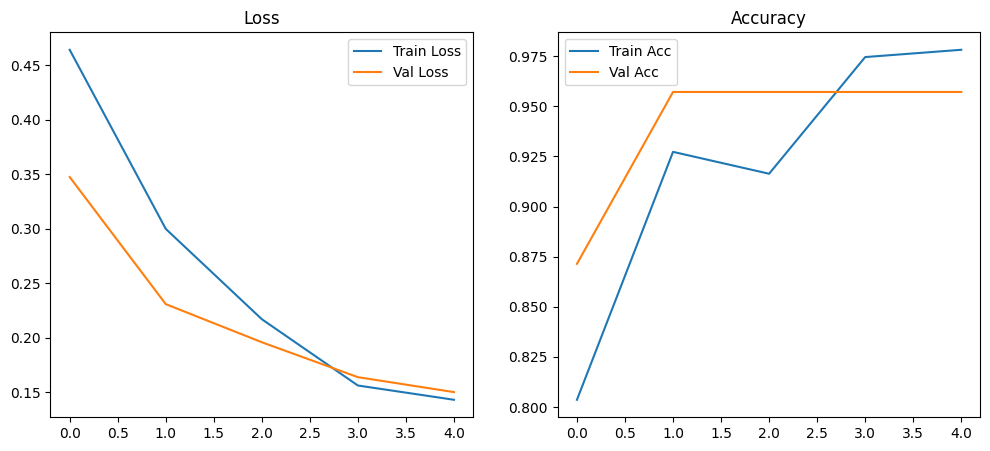

In [19]:
# Results plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title('Accuracy')
plt.show()

In [20]:
from PIL import Image
import torchvision.transforms as transforms

torch.save(model.state_dict(), 'binary_classifier.pth')

def predict_image(image_path):
    model.eval()
    img = Image.open(image_path)
    transform = data_transforms['val']
    img_t = transform(img).unsqueeze(0).to(device)

    outputs = model(img_t)
    _, pred = torch.max(outputs, 1)
    print(f"Predicted: {class_names[pred.item()]}")

In [27]:
predict_image("/content/dog-vs-cat/dataset/dogvscat/train/cat/Bengal_103_jpg.rf.bb684501a53abf381a6bf07f9cd2243c.jpg")

predict_image("/content/dog-vs-cat/dataset/dogvscat/train/dog/american_bulldog_15_jpg.rf.203ca553122b6550e27f9be376422eea.jpg")


Predicted: cat
Predicted: dog
